In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
crimes = pd.read_csv('./data/cleaned_crimes.csv')

In [3]:
crimes['date'] = pd.to_datetime(crimes['date'], format = '%m/%d/%Y %I:%M:%S %p')

In [4]:
crimes['month'] = crimes['date'].dt.to_period('M')

In [5]:
crimes['hr_of_day'] = crimes['date'].dt.hour

In [6]:
crimes['day_of_week'] = crimes['date'].dt.weekday

In [7]:
crimes.head()

,arrest,crime_description,crime_is_index,crime_type,date,domestic,fbi_code,lat,lng,location_details,neighborhood,year,location,month,hr_of_day,day_of_week
0,False,Robbery,True,Property,2010-08-27 10:00:00,False,03,41.931184,-87.772831,GROCERY FOOD STORE,BELMONT CRAGIN,2010,RETAIL,2010-08,10,4
1,True,Gambling,False,Other,2010-08-11 15:10:00,False,19,41.778381,-87.686063,SIDEWALK,CHICAGO LAWN,2010,STREET,2010-08,15,2
2,True,Misc Non-Index Offense,False,Other,2010-08-30 15:50:00,False,26,41.914482,-87.700374,"SCHOOL, PUBLIC, GROUNDS",LOGAN SQUARE,2010,OTHER,2010-08,15,0
3,True,Simple Battery,False,Violent,2010-08-31 08:00:00,True,08B,41.939962,-87.730338,RESIDENCE,IRVING PARK,2010,RESIDENCE,2010-08,8,1
4,True,Drug Abuse,False,Other,2010-07-22 06:00:00,False,18,41.953900,-87.907473,GOVERNMENT BUILDING/PROPERTY,OHARE,2010,OTHER,2010-07,6,3


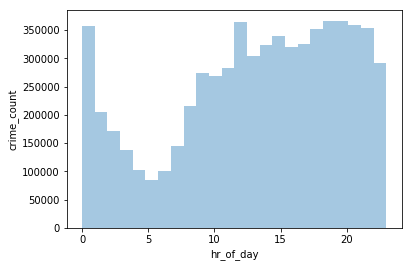

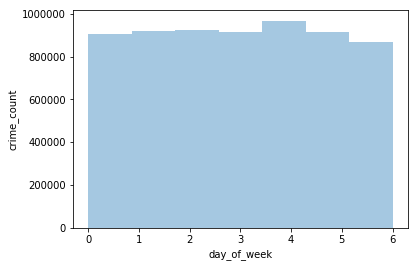

In [8]:
sns.distplot(crimes['hr_of_day'], kde = False, bins = 24).set_ylabel('crime_count')
plt.show()
sns.distplot(crimes['day_of_week'], kde = False, bins = 7).set_ylabel('crime_count')
plt.show()

## Helper functions to be migrated

In [9]:
def count_and_timeify(df, time_col, other_col):
    group_cols = [ time_col, other_col ]
    aux_col = [ col for col in df if col not in group_cols ][0]
    return df.groupby(group_cols)[[aux_col]]\
        .count().rename(columns = { aux_col : 'count' })\
        .reset_index()\
        .pivot(index = time_col, columns = other_col, values = 'count')

def multi_timeseries_explore_plot(df_ts, ylabel = None, title = None, cols_per_plot = 16):
    for i in range(len(df_ts.columns)//cols_per_plot + 1):
        cols_offset = cols_per_plot * i
        cols_to_plot = range(cols_offset,  min(len(df_ts.columns), cols_offset + cols_per_plot))
        df_ts[df_ts.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
        if title:
            plt.title(title)
        if ylabel:
            plt.ylabel(ylabel)

## Total crimes by neighborhood through time

In [10]:
crime_by_neighb_time = count_and_timeify(crimes, 'month', 'neighborhood')

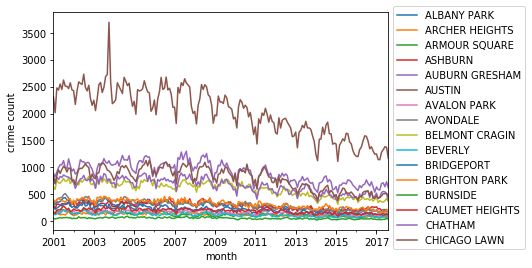

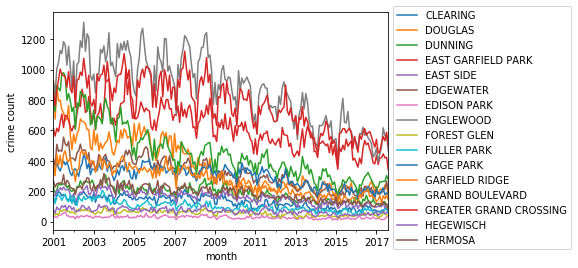

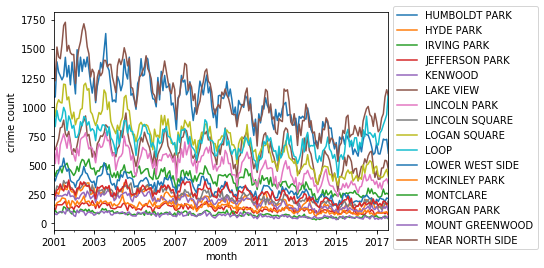

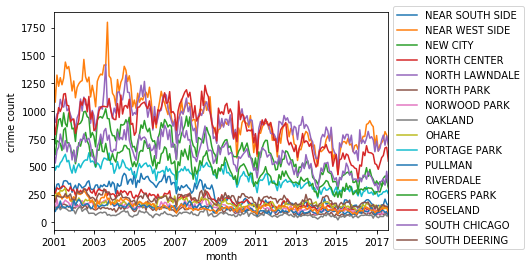

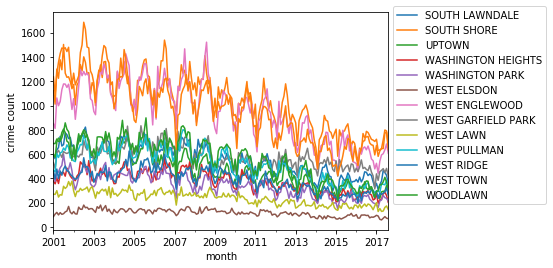

In [11]:
multi_timeseries_explore_plot(crime_by_neighb_time, ylabel = 'crime count')
plt.show()

### Total crimes by crime type through time

In [12]:
crime_by_type_time = count_and_timeify(crimes, 'month', 'crime_type')

In [13]:
crime_by_detail_type_time = count_and_timeify(crimes, 'month', 'crime_description')

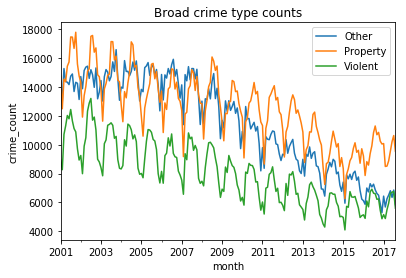

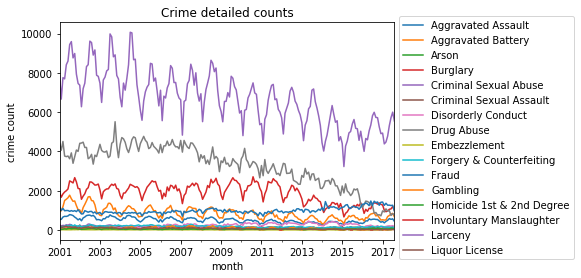

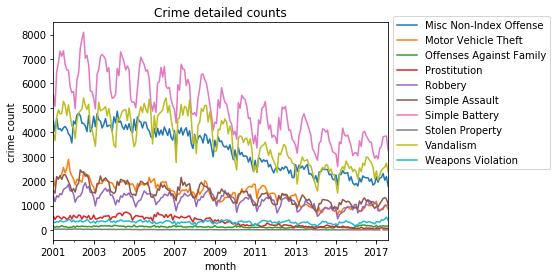

In [14]:
crime_by_type_time.plot().legend(bbox_to_anchor=(1, 1))
plt.ylabel('crime_count')
plt.title('Broad crime type counts')
multi_timeseries_explore_plot(crime_by_detail_type_time, ylabel = 'crime count', title = 'Crime detailed counts')
plt.show()

Some of the serious crimes are not very frequent. Lets go annual, and index it all to 2001.

In [15]:
crime_by_detail_type_ann = crime_by_detail_type_time.resample('A').sum().resample('M').fillna('ffill')
crime_by_detail_type_ann.index.name = 'year'

In [16]:
# Correct for the fact that we only have partial 2017 data
crime_by_detail_type_ann.loc[crime_by_detail_type_ann.index >= '2017-01'] *= 12/8

In [17]:
crime_by_detail_type_ann_indexed = crime_by_detail_type_ann.div(crime_by_detail_type_ann.iloc[0])

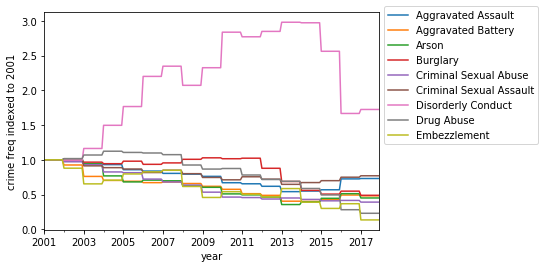

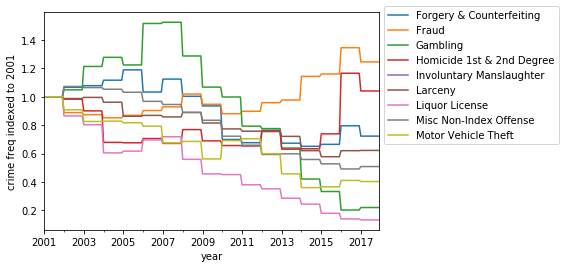

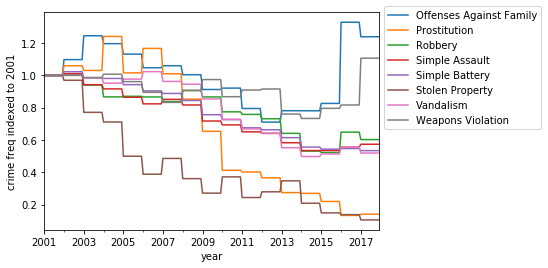

In [18]:
multi_timeseries_explore_plot(crime_by_detail_type_ann_indexed, ylabel = 'crime freq indexed to 2001', cols_per_plot=9)
plt.show()

### Arrest rates by neighborhoods by crime

Is a person more likely to be arrested committing the same crime in one location over another? That is, are some neighborhoods disproportionately incarcerated? A quick look indicates arrest rates are approximately even across locations by crime. Of course there is intra-crime variation but it's hard to distil any conclusions without a more detailed approach.

In [19]:
crime_by_neighb_type = crimes.groupby(['neighborhood', 'crime_description'])['arrest']\
    .agg(['sum', 'count'])\
    .reset_index()
crime_by_neighb_type['arrest_rate'] = crime_by_neighb_type['sum'] / crime_by_neighb_type['count']
crime_by_neighb_type = crime_by_neighb_type\
    .pivot(index = 'neighborhood', columns = 'crime_description', values = 'arrest_rate')

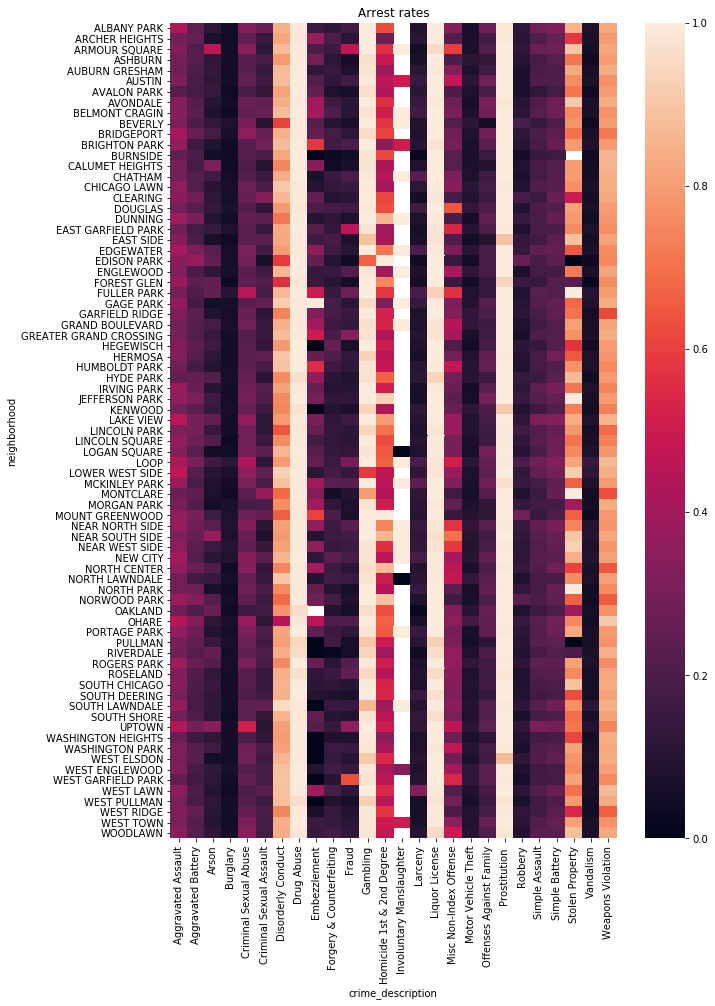

In [20]:
plt.figure(figsize = (10, 15))
sns.heatmap(crime_by_neighb_type)
plt.title('Arrest rates')
plt.show()